# Analysis on New York City Safety Data

## Dhruv Raval and Sadena Rishindran - Data Dragons

## Introduction:

Hi, we're Dhruv Raval and Sadena Rishindran. The two of us both lived and grew up in New Jersey for our entire lives. We’ve both taken many trips to New York City over the years and have grown attached to the area, as well as the idea of living there and being in close proximity to all of our family and friends. As computer science students, the two of us are both striving to work in New York City next summer as well as after graduating, and want to make sure that we can find the best place to live.

For this project, we will be aiming to analyze safety data in New York City from April 17th 2022 to May 1st 2022 and try and get a sense for the best place to live in New York City in order to live the most convenient life. In terms of the data being 'Safety Data' according to Microsoft, we have found it to be more akin to 'Service Request' data. While some of the categories we are dealing with will fall under the 'crime' category, we want to emphasize that the dataset is not all crime and involves other aspects of life in New York (which will be shown below). We hope that by analyzing this data through exploratory data analysis and statistical testing, we can find the best place to live in terms of not just safety, but also convenience and comfort.  We will be using the [New York City Safety Data](https://docs.microsoft.com/en-us/azure/open-datasets/dataset-new-york-city-safety?tabs=azureml-opendatasets) provided by Microsoft's Azure Open Datasets for our analysis.

## Part 1: Data Collection

We'll be using Python3 and the following Python libraries for this project:

In [1]:
from azureml.opendatasets import NycSafety
from datetime import datetime
from dateutil import parser
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats

The first thing we have to do in order to get our tutorial under way is convert the data into an easily accessible dataframe for future exploration and analysis. By using `dateutil` and its `parse` function, we were able to get our start and end date for the data, and then pass that into the `NycSafety` instance from the dataset. After that, we were simply able to call the `to_pandas_dataframe` function to convert our data.

Adapted from [Microsoft's Documentation](https://docs.microsoft.com/en-us/azure/open-datasets/dataset-new-york-city-safety?tabs=azureml-opendatasets)

In [2]:
start_date = parser.parse('2022-04-17')
end_date = parser.parse('2022-05-01')
data = NycSafety(start_date=start_date, end_date=end_date)
df = data.to_pandas_dataframe()
df.head()

,dataType,dataSubtype,dateTime,category,subcategory,status,address,latitude,longitude,source,extendedProperties
0,Safety,311_All,2022-04-22 15:24:00,Noise,Noise: Jack Hammering (NC2),Closed,601 WEST 26 STREET,40.750939,-74.005970,NaN,NaN
1,Safety,311_All,2022-04-19 15:57:12,PAINT/PLASTER,WALL,Closed,1596 UNIONPORT ROAD,40.840860,-73.863113,NaN,NaN
2,Safety,311_All,2022-04-27 11:47:11,Noise - Residential,Banging/Pounding,Closed,1601 DAHILL ROAD,40.608381,-73.973958,NaN,NaN
3,Safety,311_All,2022-04-22 13:11:01,Dirty Condition,Trash,Closed,517 EAST 83 STREET,40.773722,-73.947923,NaN,NaN
4,Safety,311_All,2022-04-25 10:27:16,Blocked Driveway,No Access,Closed,396 EAST 93 STREET,40.656456,-73.920274,NaN,NaN


## Part 2: Data Management and Processing

In [3]:
print(df['dataType'].unique())
print(df['source'].unique())
print(df['extendedProperties'].unique())
print(df['dataSubtype'].unique())

['Safety']
[nan]
[nan]
['311_All']


After looking at the rows above and realizing that all of them are just the same value and not relevant to our analysis, we decided that it would be best to remove these rows entirely in order to not clutter our data.

In [4]:
df = df.drop(columns=['dataType', 'dataSubtype', 'extendedProperties', 'source'])
df.head()

,dateTime,category,subcategory,status,address,latitude,longitude
0,2022-04-22 15:24:00,Noise,Noise: Jack Hammering (NC2),Closed,601 WEST 26 STREET,40.750939,-74.005970
1,2022-04-19 15:57:12,PAINT/PLASTER,WALL,Closed,1596 UNIONPORT ROAD,40.840860,-73.863113
2,2022-04-27 11:47:11,Noise - Residential,Banging/Pounding,Closed,1601 DAHILL ROAD,40.608381,-73.973958
3,2022-04-22 13:11:01,Dirty Condition,Trash,Closed,517 EAST 83 STREET,40.773722,-73.947923
4,2022-04-25 10:27:16,Blocked Driveway,No Access,Closed,396 EAST 93 STREET,40.656456,-73.920274


Now let's see how many categories of service requests there are.

In [5]:
len(df['category'].unique())

162

It would be difficult to analyze all 171 different service requests categories so for this project we're going to narrow it down to the top 5 most frequent service requests.

In [6]:
# Gets the top 5 service request categories based on frequency
requests_top_5 = df['category'].value_counts().head(5).to_dict().keys()
requests_top_5

dict_keys(['Illegal Parking', 'Noise - Residential', 'HEAT/HOT WATER', 'Blocked Driveway', 'Noise - Street/Sidewalk'])

We'll get rid of the rows that don't have a service request that are the 5 most frequent.

In [7]:
df = df[df['category'].isin(requests_top_5)]
df.head()

,dateTime,category,subcategory,status,address,latitude,longitude
2,2022-04-27 11:47:11,Noise - Residential,Banging/Pounding,Closed,1601 DAHILL ROAD,40.608381,-73.973958
4,2022-04-25 10:27:16,Blocked Driveway,No Access,Closed,396 EAST 93 STREET,40.656456,-73.920274
5,2022-04-23 19:30:26,HEAT/HOT WATER,ENTIRE BUILDING,Closed,333 EAST 150 STREET,40.817463,-73.920149
7,2022-04-28 12:01:50,HEAT/HOT WATER,ENTIRE BUILDING,Closed,3260 NETHERLAND AVENUE,40.884389,-73.911393
8,2022-04-22 19:05:16,HEAT/HOT WATER,ENTIRE BUILDING,Closed,201 HALE AVENUE,40.680177,-73.879923


Now we're going to use the [Federal Communications Commission API](https://geo.fcc.gov/api/census/) to get the county of each row based on the latitude and longitude and add it as a new column. We chose to utilize this API because after experimenting with a number of different online python libraries such as `geopy`, we found that this was not only the quickest option in terms of time (still a long time, but faster than others), but it also had the least amount of errors in terms of being able to find the correct county from the latitude and longitude. For the amount of rows in our dataset, this API took about 2 hours to find the county of each row.

In [8]:
df['county'] = np.NaN

# Iterates through the dataset and calls API for each latitude and longitude pair
for index, row in df.iterrows():
    latitude = df.at[index, 'latitude']
    longitude = df.at[index, 'longitude']
    res = requests.get(f"https://geo.fcc.gov/api/census/block/find?latitude={latitude}&longitude={longitude}&censusYear=2020&format=json")

    # Checks error if API can't find county name
    if 'County' in res.json().keys() and 'name' in res.json()['County'].keys():
        county = res.json()['County']['name']
        df.loc[index, 'county'] = county
df.head()

,dateTime,category,subcategory,status,address,latitude,longitude,county
2,2022-04-27 11:47:11,Noise - Residential,Banging/Pounding,Closed,1601 DAHILL ROAD,40.608381,-73.973958,Kings County
4,2022-04-25 10:27:16,Blocked Driveway,No Access,Closed,396 EAST 93 STREET,40.656456,-73.920274,Kings County
5,2022-04-23 19:30:26,HEAT/HOT WATER,ENTIRE BUILDING,Closed,333 EAST 150 STREET,40.817463,-73.920149,Bronx County
7,2022-04-28 12:01:50,HEAT/HOT WATER,ENTIRE BUILDING,Closed,3260 NETHERLAND AVENUE,40.884389,-73.911393,Bronx County
8,2022-04-22 19:05:16,HEAT/HOT WATER,ENTIRE BUILDING,Closed,201 HALE AVENUE,40.680177,-73.879923,Kings County


Now we're going to get rid of the rows that don't have a county.

In [9]:
df = df.dropna(subset=['county'])

Each of the boroughs in New York City [correspond to counties](https://portal.311.nyc.gov/article/?kanumber=KA-02877) so we're going to add a column with the borough of each row based on the county. If a given county does't correspond to a borough (aka it is not in the dictionary below), we'll drop that row.

In [10]:
# Dictionary of each county and which borough it corresponds to
county_to_borough = {"Bronx County": "Bronx",
                     "Kings County": "Brooklyn",
                     "New York County": "Manhattan",
                     "Queens County": "Queens",
                     "Richmond County": "Staten Island"}
# Adds a column for the borough based on the county for each row  
df['borough'] = df['county'].apply(lambda x:county_to_borough[x] if x in county_to_borough.keys() else np.NaN)
df = df.dropna(subset=['borough'])
df.head()

,dateTime,category,subcategory,status,address,latitude,longitude,county,borough
2,2022-04-27 11:47:11,Noise - Residential,Banging/Pounding,Closed,1601 DAHILL ROAD,40.608381,-73.973958,Kings County,Brooklyn
4,2022-04-25 10:27:16,Blocked Driveway,No Access,Closed,396 EAST 93 STREET,40.656456,-73.920274,Kings County,Brooklyn
5,2022-04-23 19:30:26,HEAT/HOT WATER,ENTIRE BUILDING,Closed,333 EAST 150 STREET,40.817463,-73.920149,Bronx County,Bronx
7,2022-04-28 12:01:50,HEAT/HOT WATER,ENTIRE BUILDING,Closed,3260 NETHERLAND AVENUE,40.884389,-73.911393,Bronx County,Bronx
8,2022-04-22 19:05:16,HEAT/HOT WATER,ENTIRE BUILDING,Closed,201 HALE AVENUE,40.680177,-73.879923,Kings County,Brooklyn


To avoid having to load the dataset from azureml and process the data with the [Federal Communications Commission API](https://geo.fcc.gov/api/census/) repeatedly, which took an excessive amount of time the first time around, we decided to save the dataframe to a csv file for our own convenience.

In [11]:
df.to_csv('nyc_safety.csv', index=False)

In [12]:
df = pd.read_csv("nyc_safety.csv")
df.head()

,dateTime,category,subcategory,status,address,latitude,longitude,county,borough
0,2022-04-27 11:47:11,Noise - Residential,Banging/Pounding,Closed,1601 DAHILL ROAD,40.608381,-73.973958,Kings County,Brooklyn
1,2022-04-25 10:27:16,Blocked Driveway,No Access,Closed,396 EAST 93 STREET,40.656456,-73.920274,Kings County,Brooklyn
2,2022-04-23 19:30:26,HEAT/HOT WATER,ENTIRE BUILDING,Closed,333 EAST 150 STREET,40.817463,-73.920149,Bronx County,Bronx
3,2022-04-28 12:01:50,HEAT/HOT WATER,ENTIRE BUILDING,Closed,3260 NETHERLAND AVENUE,40.884389,-73.911393,Bronx County,Bronx
4,2022-04-22 19:05:16,HEAT/HOT WATER,ENTIRE BUILDING,Closed,201 HALE AVENUE,40.680177,-73.879923,Kings County,Brooklyn


We'll convert the datetime column to a datetime object to make it easier to work with.

In [13]:
df['dateTime'] = pd.to_datetime(df['dateTime'])

## Part 3: Exploratory Data Analysis

### Distribution of the Hour of Day of Service Requests

Let's see what the distribution of the time of day these services are requested. For this we'll plot the data on a histogram. For each of the five service requests, we made a histogram will the frequency of that request for each hour of the day.

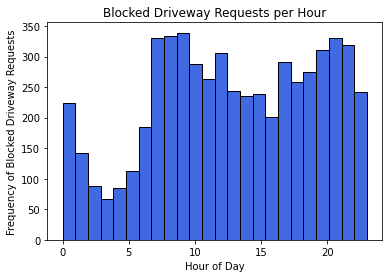

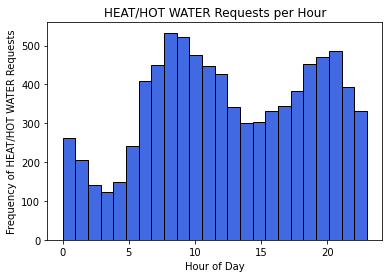

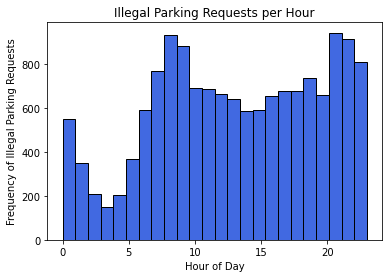

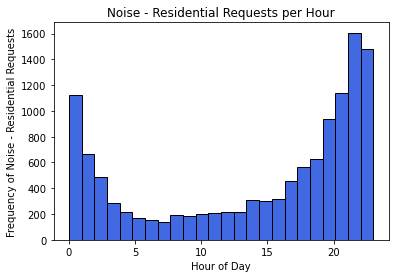

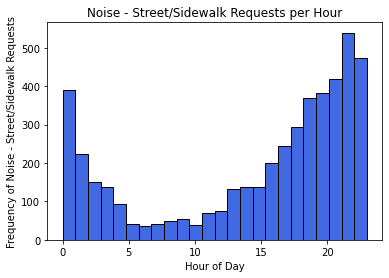

In [14]:
for name, group in df.groupby('category'):
    fig, ax = plt.subplots()
    # Creates a histogram with the frequency of requests per hour
    ax.hist(group['dateTime'].dt.hour, bins=24, color="royalblue", edgecolor='black')
    # Adds labels to histogram
    plt.title(f"{name} Requests per Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel(f"Frequency of {name} Requests")
    plt.show()

From these histograms we can see that the most noise service requests occurred at night and much less during the day. Blocked driveway, heat/hot water, and illegal parking requests all had a similar distribution of requests throughout the day. The histograms of those three had dips around 3-5 am. This could due to most people being asleep around then and not calling in these service requests.

### Frequency of Service Requests per Day of the Week

Now we'll create a histogram to see the frequency of each service request for each day of the week. The day of the week can be accessed with the datetime object with Monday = 0 and Sunday = 6.

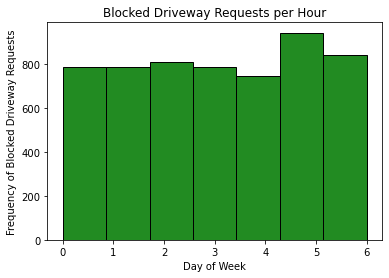

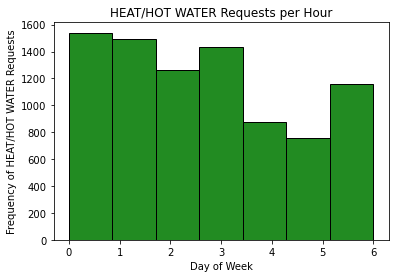

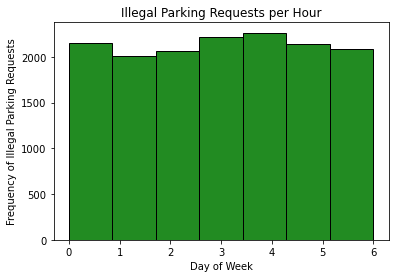

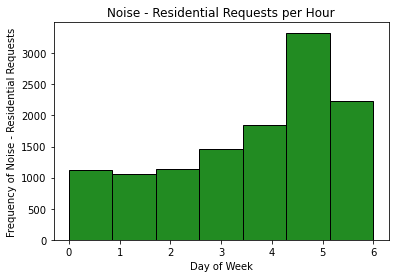

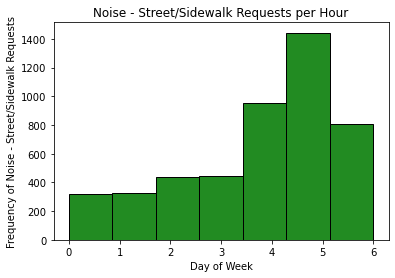

In [34]:
for name, group in df.groupby('category'):
    fig, ax = plt.subplots()
    # Creates a histogram with the frequency of requests per day of the week
    ax.hist(group['dateTime'].dt.dayofweek, bins=7, color="forestgreen", edgecolor='black')
    # Adds labels to histogram
    plt.title(f"{name} Requests per Hour")
    plt.xlabel("Day of Week")
    plt.ylabel(f"Frequency of {name} Requests")
    plt.show()

From this we can see that the noise service requests happen the most on Saturday with Friday and Sunday being the 2nd and 3rd highest. This makes sense because most people will be loud on the weekends. Heat/hot water service requests occurred the most on the weekdays with the least requests happening on Friday and Saturday. This could be due to requests being addressed and fixed on weekdays rather than on weekends so people might call on those days. Blocked driveways and illegal parking don't seem to have any differences in frequency of the requests based on the day of the week.

### Status of Different Service Requets

Now we're going to explore the differences between the status of each service request.

In [16]:
for name, group in df.groupby('category'):
    print(f"{name}: {group['status'].value_counts().to_dict()}")

Blocked Driveway: {'Closed': 5706}
HEAT/HOT WATER: {'Closed': 8511, 'Open': 6}
Illegal Parking: {'Closed': 14926, 'In Progress': 4}
Noise - Residential: {'Closed': 12194}
Noise - Street/Sidewalk: {'Closed': 4729}


We can see that heat/hot water is the only one with the service requests still open and unresolved. The illegal parking is the only one with requests in progress and has 4 in progress. We are looking at data from April 17th, 2022 to May 1st, 2022, so it makes sense that most of these service requests have been closed. It has been two to four weeks since all these requests, so those requests have been addressed already. Heat/hot water issues take longer to fix so it makes sense that that is the only one with open requests still.

### Service Requests Across Boroughs

Another thing we thought to analyze was how service requests are spread across boroughs (i.e. which boroughs have the most and least service requests). We wanted to explore this because it makes logical sense that the borough with the least requests would be the most convenient, and therefore the best place to live (if we were looking in a vacuum of convenience).

To start, we create a dictionary mapping the boroughs to another dictionary, which maps the type of service request to the count of that service request for that specific borough. We accomplish this by getting a list of the unique boroughs and categories before looping through the boroughs and creating a key-value pair with a key of the borough and value of an empty dictionary. We then populate this dictionary with 6 keys, one being the total number of requests, and the rest being the top 5 incident categories we have defined in our data management section. The results of this dictionary are printed in an easy to read format below.

In [17]:
safety_dict = {}
boroughs = df['borough'].unique()
categories = df['category'].unique()

print('\033[1m' + 'Service Request Data by Borough:\n') # `\033[1m used to create bold text

for borough in boroughs:
    print('\033[1m' + borough + ':')
    
    safety_dict[borough] = {}
    borough_df = df.loc[df['borough'] == borough]
    
    # Total requests will be the size of the dataframe that is just elements from a specific borough
    safety_dict[borough]['total'] = len(borough_df) 
    
    print('\t' + '\033[0m' + 'Total Requests: ' + str(safety_dict[borough]['total']))

    # Goes through each category for each borough and populates map
    for category in categories:
        category_df = borough_df[borough_df['category'] == category]
        safety_dict[borough][category] = len(category_df)
        
        print('\t' + '\033[0m' + category + ': ' + str(safety_dict[borough][category]))

Service Request Data by Borough:

Brooklyn:
	Total Requests: 13689
	Noise - Residential: 2969
	Blocked Driveway: 2008
	HEAT/HOT WATER: 2178
	Illegal Parking: 5361
	Noise - Street/Sidewalk: 1173
Bronx:
	Total Requests: 11849
	Noise - Residential: 3986
	Blocked Driveway: 984
	HEAT/HOT WATER: 2971
	Illegal Parking: 2749
	Noise - Street/Sidewalk: 1159
Queens:
	Total Requests: 10849
	Noise - Residential: 2465
	Blocked Driveway: 2398
	HEAT/HOT WATER: 1256
	Illegal Parking: 4177
	Noise - Street/Sidewalk: 553
Manhattan:
	Total Requests: 8689
	Noise - Residential: 2427
	Blocked Driveway: 185
	HEAT/HOT WATER: 2023
	Illegal Parking: 2250
	Noise - Street/Sidewalk: 1804
Staten Island:
	Total Requests: 1000
	Noise - Residential: 347
	Blocked Driveway: 131
	HEAT/HOT WATER: 89
	Illegal Parking: 393
	Noise - Street/Sidewalk: 40


From this data, we can see that Brooklyn has the most service requests and Staten Island has the least (by far). However, this is hard to draw conclusions from as each of the boroughs has a different number of people, as well as takes up a different amount of space. While this data serves as a good baseline, it would benefit us to look at incidents per person as well as per unit of area, which is exactly what we will do.

After conducting research (source below), we were able to find the population of each of the 5 New York City boroughs as estimated on July 1st, 2021 by the [US Census](https://www.census.gov/quickfacts/fact/table/richmondcountynewyork,newyorkcountynewyork,queenscountynewyork,kingscountynewyork,bronxcountynewyork/PST045221). By dividing the numbers shown above by these numbers for each respective borough, we were able to effectively create a dictionary similar to the previous one, but instead of showing the raw number of service requests, it shows the number of service requests per capita, which gives us a better perspective. Below is the population data for each of the 5 boroughs:

Queens : 2,331,143

Brooklyn : 2,641,052

Bronx : 1,424,948

Manhattan : 1,576,876

Staten Island : 493,494

In [18]:
population_map = {'Queens' : 2331143, 'Brooklyn' : 2641052, 'Bronx' : 1424948, 'Manhattan' : 1576876, "Staten Island" : 493494}
safety_dict_pop = {}

print('\033[1m' + 'Service Request Data per Capita by Borough:\n') # `\033[1m used to create bold text 

for borough in boroughs:
    print('\033[1m' + borough + ':')
    
    safety_dict_pop[borough] = {}
    borough_df = df.loc[df['borough'] == borough]

    # Total requests will be the size of the dataframe that is just elements from a specific borough
    safety_dict_pop[borough]['total'] = (len(borough_df) / population_map[borough])
    
    print('\t' + '\033[0m' + 'Total Requests: ' + str(safety_dict_pop[borough]['total']))

    # Goes through each category for each borough and populates map
    for category in categories:
        category_df = borough_df[borough_df['category'] == category]
        safety_dict_pop[borough][category] = (len(category_df) / population_map[borough])
        
        print('\t' + '\033[0m' + category + ': ' + str(safety_dict_pop[borough][category]))

Service Request Data per Capita by Borough:

Brooklyn:
	Total Requests: 0.005183161861258317
	Noise - Residential: 0.001124173246115563
	Blocked Driveway: 0.0007603030913439038
	HEAT/HOT WATER: 0.0008246713809497124
	Illegal Parking: 0.0020298729445690582
	Noise - Street/Sidewalk: 0.0004441411982800793
Bronx:
	Total Requests: 0.008315391158133489
	Noise - Residential: 0.002797295059188125
	Blocked Driveway: 0.0006905515148622968
	HEAT/HOT WATER: 0.0020849883644876864
	Illegal Parking: 0.0019291932056468026
	Noise - Street/Sidewalk: 0.0008133630139485792
Queens:
	Total Requests: 0.004653940148673848
	Noise - Residential: 0.0010574211878035796
	Blocked Driveway: 0.0010286799222527319
	HEAT/HOT WATER: 0.0005387914855502215
	Illegal Parking: 0.001791824868744646
	Noise - Street/Sidewalk: 0.00023722268432266918
Manhattan:
	Total Requests: 0.005510262062457669
	Noise - Residential: 0.001539119119068335
	Blocked Driveway: 0.00011732057561913556
	HEAT/HOT WATER: 0.0012829163485270877
	Illegal 

In addition to calculating the number of requests per capita, we thought it would also be best to get numbers for the number of requests per a certain unit of area. With both this data and the per capita data, we felt that we would be able to create a general consensus on which borough had the least requests. Once again using the [US Census](https://www.census.gov/quickfacts/fact/table/richmondcountynewyork,newyorkcountynewyork,queenscountynewyork,kingscountynewyork,bronxcountynewyork/PST045221) data, we were able to find all of the areas of the 5 boroughs in square miles (listed below). With a similar process to the previous map, we divided each of the values in our original safety dictionary by the areas in square miles, effectively getting the number of service requests of a specific category per square mile for each borough.

Queens : 108.53

Brooklyn : 70.82

Bronx : 42.10

Manhattan : 22.83

Staten Island : 58.37

In [19]:
area_map = {'Queens' : 108.53, 'Brooklyn' : 70.82, 'Bronx' : 42.10, 'Manhattan' : 22.83, "Staten Island" : 58.37}
safety_dict_area = {}

print('\033[1m' + 'Service Request Data per Square Mile by Borough:\n') # `\033[1m used to create bold text 

for borough in boroughs:
    print('\033[1m' + borough + ':')
    
    safety_dict_area[borough] = {}
    borough_df = df.loc[df['borough'] == borough]

    # Total requests will be the size of the dataframe that is just elements from a specific borough
    safety_dict_area[borough]['total'] = (len(borough_df) / area_map[borough])
    
    print('\t' + '\033[0m' + 'Total Requests: ' + str(safety_dict_area[borough]['total']))

    # Goes through each category for each borough and populates map
    for category in categories:
        category_df = borough_df[borough_df['category'] == category]
        safety_dict_area[borough][category] = (len(category_df) / area_map[borough])
        
        print('\t' + '\033[0m' + category + ': ' + str(safety_dict_area[borough][category]))

Service Request Data per Square Mile by Borough:

Brooklyn:
	Total Requests: 193.29285512567074
	Noise - Residential: 41.92318554080769
	Blocked Driveway: 28.353572437164644
	HEAT/HOT WATER: 30.7540242869246
	Illegal Parking: 75.69895509743012
	Noise - Street/Sidewalk: 16.56311776334369
Bronx:
	Total Requests: 281.44893111638953
	Noise - Residential: 94.6793349168646
	Blocked Driveway: 23.3729216152019
	HEAT/HOT WATER: 70.57007125890736
	Illegal Parking: 65.29691211401425
	Noise - Street/Sidewalk: 27.529691211401424
Queens:
	Total Requests: 99.96314383119875
	Noise - Residential: 22.71261402377223
	Blocked Driveway: 22.09527319635124
	HEAT/HOT WATER: 11.572837003593476
	Illegal Parking: 38.48705427070856
	Noise - Street/Sidewalk: 5.095365336773242
Manhattan:
	Total Requests: 380.59570740254054
	Noise - Residential: 106.30749014454666
	Blocked Driveway: 8.103372755146736
	HEAT/HOT WATER: 88.6114761279019
	Illegal Parking: 98.5545335085414
	Noise - Street/Sidewalk: 79.01883486640386
Stat

Now that we have data in maps of the number of requests per borough, as well as per borough per capita and per borough per square mile, we can visualize the data to show how the factors make the data different, as well as start to explore which borough is "the safest".

We start by visualizing the number of requests per borough without any interaction. Using `matplotlib`, we created a bar graph with 5 bars for each type of request we are looking at (each bar representing a different borough of New York City).

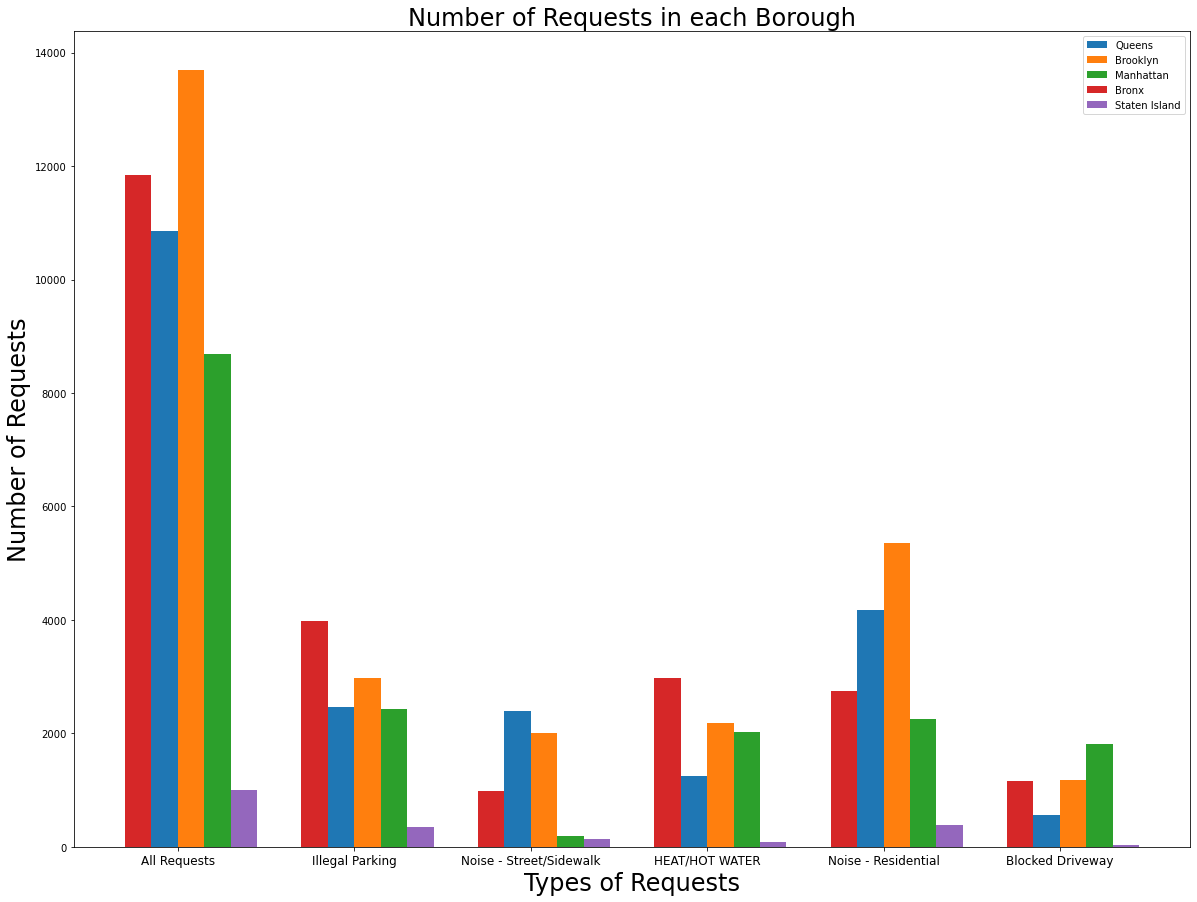

In [20]:
x_labels = ['All Requests', 'Illegal Parking', 'Noise - Street/Sidewalk', 'HEAT/HOT WATER', 'Noise - Residential', 'Blocked Driveway']
x_axis = np.arange(len(x_labels))

plt.figure(figsize=(20,15))

# Offsetting the bars so that they do not overlap
plt.bar(x_axis - 0.075, safety_dict['Queens'].values(), 0.15, label = 'Queens')
plt.bar(x_axis + 0.075, safety_dict['Brooklyn'].values(), 0.15, label = 'Brooklyn')
plt.bar(x_axis + 0.225, safety_dict['Manhattan'].values(), 0.15, label = 'Manhattan')
plt.bar(x_axis - 0.225, safety_dict['Bronx'].values(), 0.15, label = 'Bronx')
plt.bar(x_axis + 0.375, safety_dict['Staten Island'].values(), 0.15, label = 'Staten Island')

# Adding labels to x-axis and appropriate titles
plt.xticks(x_axis, x_labels, fontsize=12)
plt.xlabel("Types of Requests", fontsize=24)
plt.ylabel("Number of Requests", fontsize=24)
plt.title("Number of Requests in each Borough", fontsize=24)
plt.legend()
plt.show()

We repeat the same process for the data per capita.

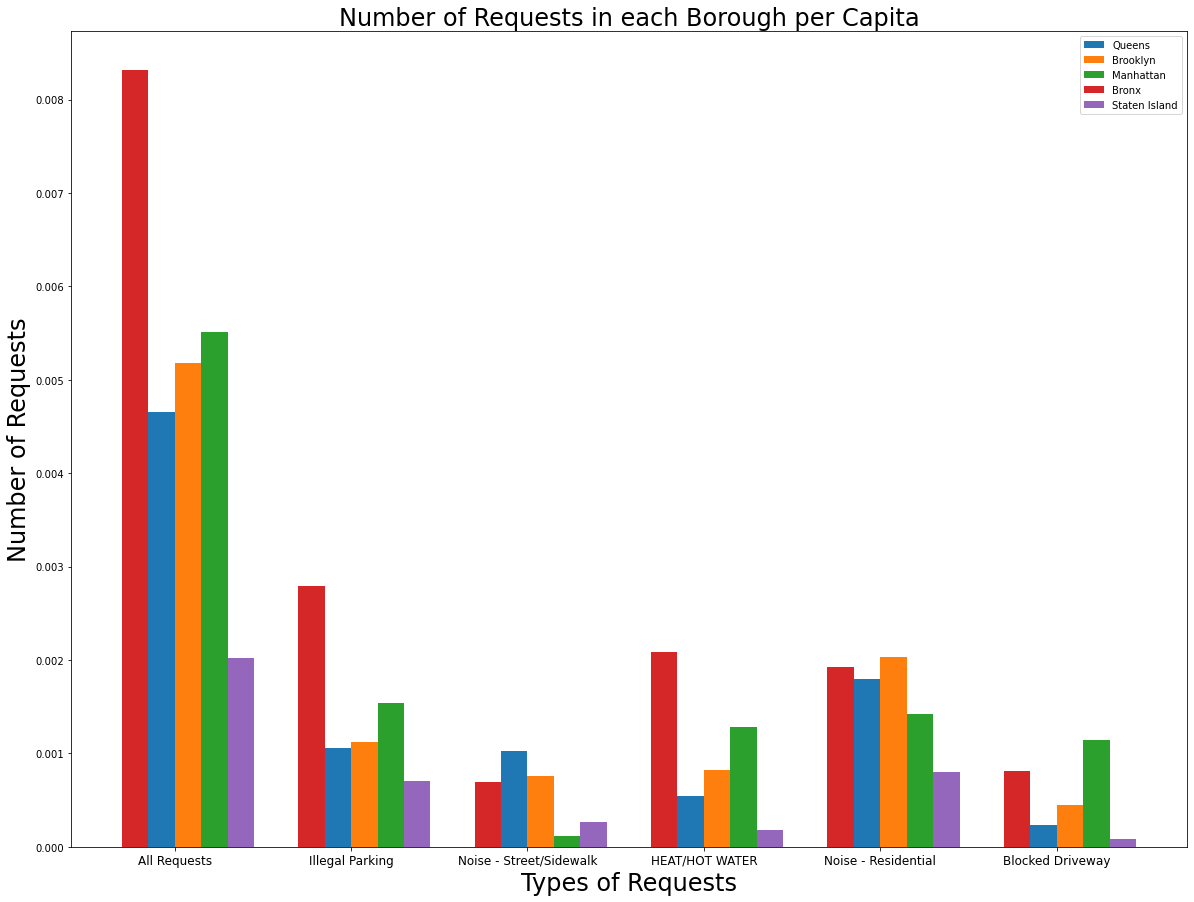

In [21]:
x_labels = ['All Requests', 'Illegal Parking', 'Noise - Street/Sidewalk', 'HEAT/HOT WATER', 'Noise - Residential', 'Blocked Driveway']
x_axis = np.arange(len(x_labels))

plt.figure(figsize=(20,15))

# Offsetting the bars so that they do not overlap
plt.bar(x_axis - 0.075, safety_dict_pop['Queens'].values(), 0.15, label = 'Queens')
plt.bar(x_axis + 0.075, safety_dict_pop['Brooklyn'].values(), 0.15, label = 'Brooklyn')
plt.bar(x_axis + 0.225, safety_dict_pop['Manhattan'].values(), 0.15, label = 'Manhattan')
plt.bar(x_axis - 0.225, safety_dict_pop['Bronx'].values(), 0.15, label = 'Bronx')
plt.bar(x_axis + 0.375, safety_dict_pop['Staten Island'].values(), 0.15, label = 'Staten Island')

# Adding labels to x-axis and appropriate titles
plt.xticks(x_axis, x_labels, fontsize=12)
plt.xlabel("Types of Requests", fontsize=24)
plt.ylabel("Number of Requests", fontsize=24)
plt.title("Number of Requests in each Borough per Capita", fontsize=24)
plt.legend()
plt.show()

Finally, we repeat the process for data per square mile.

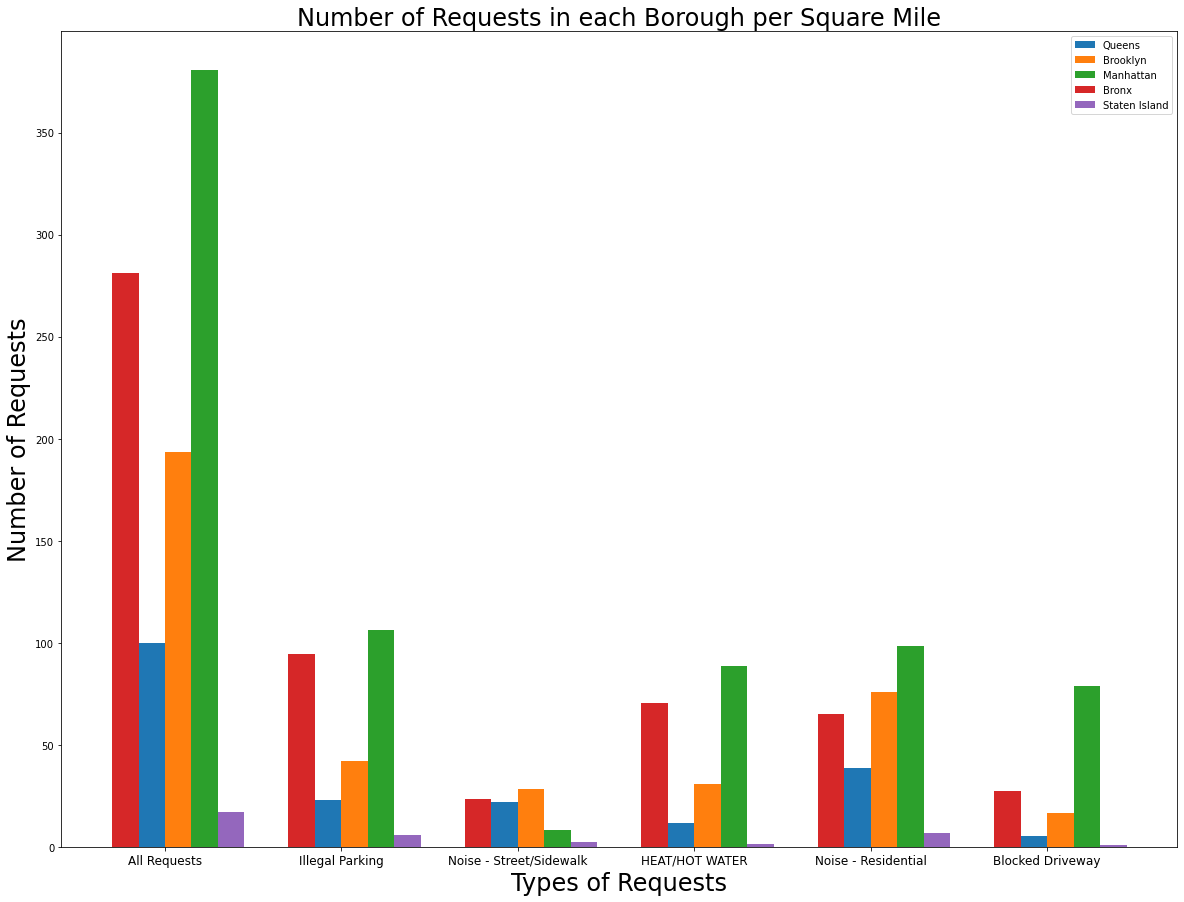

In [22]:
x_labels = ['All Requests', 'Illegal Parking', 'Noise - Street/Sidewalk', 'HEAT/HOT WATER', 'Noise - Residential', 'Blocked Driveway']
x_axis = np.arange(len(x_labels))

plt.figure(figsize=(20,15))

# Offsetting the bars so that they do not overlap
plt.bar(x_axis - 0.075, safety_dict_area['Queens'].values(), 0.15, label = 'Queens')
plt.bar(x_axis + 0.075, safety_dict_area['Brooklyn'].values(), 0.15, label = 'Brooklyn')
plt.bar(x_axis + 0.225, safety_dict_area['Manhattan'].values(), 0.15, label = 'Manhattan')
plt.bar(x_axis - 0.225, safety_dict_area['Bronx'].values(), 0.15, label = 'Bronx')
plt.bar(x_axis + 0.375, safety_dict_area['Staten Island'].values(), 0.15, label = 'Staten Island')

# Adding labels to x-axis and appropriate titles
plt.xticks(x_axis, x_labels, fontsize=12)
plt.xlabel("Types of Requests", fontsize=24)
plt.ylabel("Number of Requests", fontsize=24)
plt.title("Number of Requests in each Borough per Square Mile", fontsize=24)
plt.legend()
plt.show()

As we can see, the introduction of factors such as per capita and per square mile do impact our data, at least visually. For instance, Brooklyn by far has the most requests when just looking at the raw data, but we see that characteristic change with the Bronx having the most requests per capita and Manhattan (likely due to its dense nature) having the most requests per square mile.

In general, Manhattan's number of requests gets relatively larger with per capita and per square mile data. Despite having the 2nd least number of total requests, the borough has the 2nd most requests per capita and the most per square mile. This phenomena shows the entire reason we wanted to conduct this analysis, as we knew the data may be skewed due to different geographical and demographical traits in the different boroughs.

One thing that has stayed consistent with the data is that Staten Island has the least number of requests in every category, with and without the per capita and per square mile adjustments. This can largely be attributed to the fact that the borough is somewhat isolated from the others and largely outside the "hussle and bussle" normally associated with New York City.

Our bar graphs also show us that some boroughs have a concentration of requests in one or two large areas. For instance, the Bronx seems to have a majority of its requests come from residential noise and heat/hot water. This is a contrast to Brooklyn, whose biggest problem in terms of safety data seems to lie in illegal parking. Queens, who ranks towards the bottom end of the spectrum in terms of requests, seems to have little problem with noise and much more with traffic (illegal parking and blocked driveways).

## Part 4: Analysis and Hypothesis Testing

To start off our testing, we wanted to look at the idea we explored in the data analysis regarding the difference between convenience in separate boroughs. Since we have 5 boroughs, we thought the best way to accomplish this was by using an ANOVA test, using each borough as a different treatment. The idea behind this was to take each of the days in our sample (14, 2 weeks) and calculate the number of requests made that day for that borough. This would give us 5 treatment groups of size J = 14, and then we could run the ANOVA on these groups to see if there was a statistically significant difference.

To start off, we needed to isolate our datetime into just dates, as looking at individual datetimes would not make any sense (likely only 1 request per datetime), so we map our "dateTime" column in the original dataframe to just the date and get the unique values.

In [23]:
dates = df["dateTime"].map(pd.Timestamp.date).unique() # Using pd.Timestamp.date to get just date of dateTime object
dates.sort()
print(dates)

[datetime.date(2022, 4, 17) datetime.date(2022, 4, 18)
 datetime.date(2022, 4, 19) datetime.date(2022, 4, 20)
 datetime.date(2022, 4, 21) datetime.date(2022, 4, 22)
 datetime.date(2022, 4, 23) datetime.date(2022, 4, 24)
 datetime.date(2022, 4, 25) datetime.date(2022, 4, 26)
 datetime.date(2022, 4, 27) datetime.date(2022, 4, 28)
 datetime.date(2022, 4, 29) datetime.date(2022, 4, 30)]


Now, we create the dataframe that we will use for our ANOVA test. Since we are looking at the 5 boroughs as our treatment groups, we take each one of them and make it a header for the column. Then after populating the dates, we loop through each borough for each date and create an array of requests per capita for that day. The reason we are choosing use per-capita is due to our exploratory data analysis above. We recognized that from our bar graphs, the data regarding requests can change drastically. We felt that if we used this data rather than the raw request data, we could get a better sense as to whether or not there was a statistically significant difference between each borough. We will also conduct another ANOVA with per square mile data later.

In [24]:
anova_df = pd.DataFrame(columns = ['Date', 'Manhattan', 'Queens', 'Bronx', 'Staten Island', 'Brooklyn'])
anova_df['Date'] = dates
for borough in boroughs:
    res = [] # Empty result array for eventual data
    borough_df = df.loc[df['borough'] == borough]
    for date in dates:
        temp_df = borough_df.loc[borough_df['dateTime'].dt.date == date]
        res.append(len(temp_df)/population_map[borough]) # getting number of requests per capita for specific borough on specific date
    anova_df[borough] = res # Adding resultant array to dataframe
anova_df   

,Date,Manhattan,Queens,Bronx,Staten Island,Brooklyn
0,2022-04-17,0.000344,0.000372,0.000564,0.000136,0.000368
1,2022-04-18,0.000358,0.000304,0.000533,0.000107,0.000296
2,2022-04-19,0.000330,0.000278,0.000552,0.000109,0.000318
3,2022-04-20,0.000356,0.000275,0.000463,0.000103,0.000336
4,2022-04-21,0.000335,0.000276,0.000707,0.000097,0.000332
5,2022-04-22,0.000403,0.000296,0.000493,0.000142,0.000374
6,2022-04-23,0.000545,0.000426,0.001000,0.000209,0.000432
7,2022-04-24,0.000413,0.000443,0.000648,0.000211,0.000436
8,2022-04-25,0.000358,0.000324,0.000498,0.000152,0.000365
9,2022-04-26,0.000332,0.000295,0.000458,0.000158,0.000338


When running an ANOVA, you want your data to come from a normally distributed population. Utilizing scipy, we can create normal probability plots [qq-plots](https://analyse-it.com/docs/user-guide/distribution/continuous/normal-probability-plot#:~:text=A%20normal%20probability%20plot%2C%20or,approximately%20on%20a%20straight%20line) for each of our 5 boroughs. Essentially, these qq-plots show the distribution of the specified data points compared against an expected normal distribution.

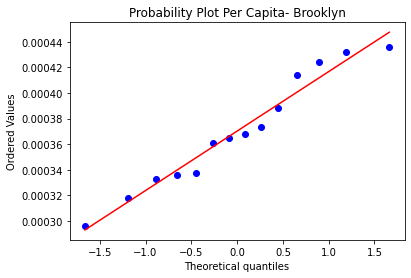

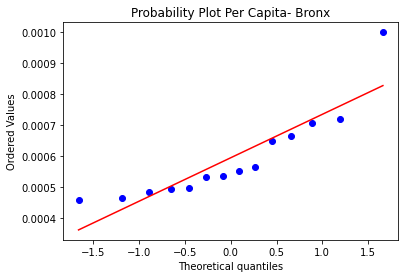

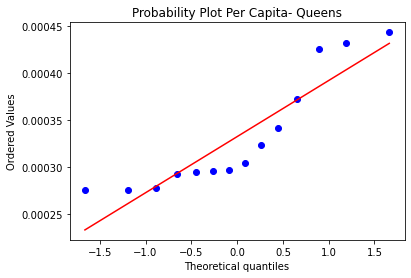

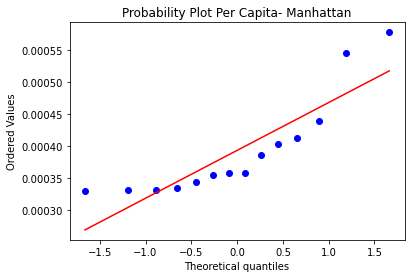

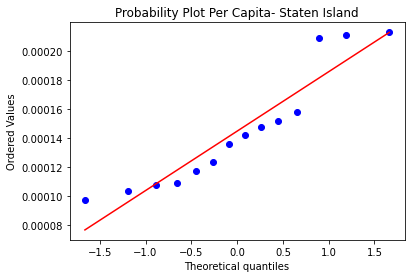

In [25]:
for borough in boroughs:
    stats.probplot(anova_df[borough], dist="norm", plot=plt) # Creating qq-plot using scipy
    plt.title("Probability Plot Per Capita- " +  borough)
    plt.show()

As we can see, our data isn't 100% normal, but is fitting the distribution with the exception of a few outliers. However, our data is being sampled from a population of nearly 12 million (according to the dataset's webpage), and if we were to graph all of these points, we would be able to show a graph that better fits the normal distribution, as there would be more data points to make up for the outliers.

In [26]:
fvalue, pvalue = stats.f_oneway(anova_df['Manhattan'], anova_df['Queens'], anova_df['Bronx'], anova_df['Brooklyn'], anova_df['Staten Island']) #getting p-value from scipy one-way anova test
print("F Value: " + str(fvalue))
print("P Value: " + str(pvalue))

F Value: 51.428457508334716
P Value: 1.8748633467363924e-19


As we can see, our p value is far below our siginificance level of 0.05. This means that we reject our null hypothesis and can conclude that there is at least 2 significantly different population means when it comes to requests per capita per day. Therefore, we can conclude that when looking at requests per capita, there is a difference in at least 2 of the 5 boroughs.

Now that we have shown significant difference in terms of requests per capita, we want to do the same per day. Therefore, we repeat the process, this time dividing by area in square miles for each borough.

In [27]:
for borough in boroughs:
    res = [] # Creating empy resultant array
    borough_df = df.loc[df['borough'] == borough]
    for date in dates:
        temp_df = borough_df.loc[borough_df['dateTime'].dt.date == date]
        res.append(len(temp_df)/area_map[borough]) # Adding number of requests per day per square mile to resultant array
    anova_df[borough] = res # Adding resultant array to dataframe
anova_df

,Date,Manhattan,Queens,Bronx,Staten Island,Brooklyn
0,2022-04-17,23.784494,7.997789,19.073634,1.147850,13.724936
1,2022-04-18,24.748138,6.532756,18.028504,0.908001,11.042079
2,2022-04-19,22.820850,5.979913,18.693587,0.925133,11.846936
3,2022-04-20,24.572930,5.915415,15.676960,0.873737,12.538831
4,2022-04-21,23.127464,5.933843,23.919240,0.822340,12.397628
5,2022-04-22,27.858081,6.366903,16.674584,1.199246,13.936741
6,2022-04-23,37.669733,9.140330,33.847981,1.764605,16.111268
7,2022-04-24,28.515112,9.518106,21.947743,1.781737,16.266591
8,2022-04-25,24.704336,6.956602,16.840855,1.284907,13.611974
9,2022-04-26,22.908454,6.330047,15.510689,1.336303,12.595312


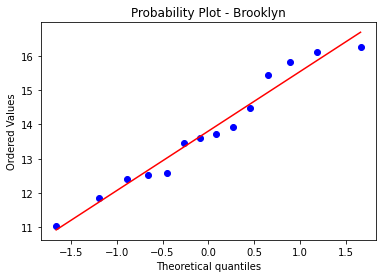

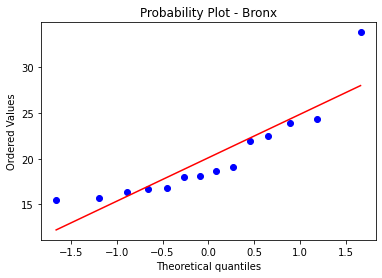

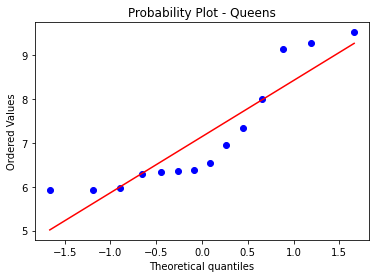

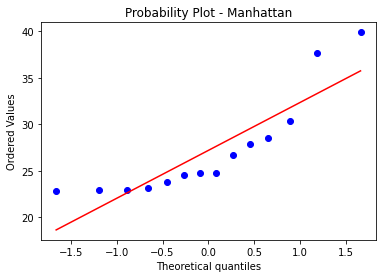

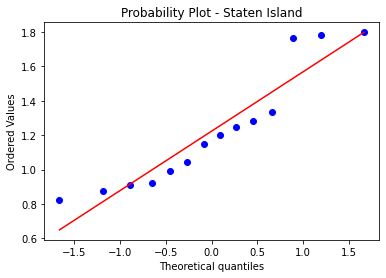

In [28]:
for borough in boroughs:
    stats.probplot(anova_df[borough], dist="norm", plot=plt) # creating qq-plot
    plt.title("Probability Plot - " +  borough)
    plt.show()

Our probability plots are identical to those used for the per capita ANOVA, and we utilize the same reasoning to justify the normality of the population.

Our null hypothesis will be the same as before: there is no difference in terms of true population mean of requests per day per square mile across the 5 boroughs. Our alternative hypothesis also takes a similar approach as before, as we will state that there are at least 2 significantly different true population means in terms of requests per day per square mile across the 5 boroughs. Once again, we will utilize a significance level of 0.05 for simplicity.

In [29]:
fvalue, pvalue = stats.f_oneway(anova_df['Manhattan'], anova_df['Queens'], anova_df['Bronx'], anova_df['Brooklyn'], anova_df['Staten Island'])
print("F Value: " + str(fvalue))
print("P Value: " + str(pvalue))

F Value: 125.2508069226946
P Value: 8.449182850417577e-30


As we can clearly see, our p-value lies far below the significance level of 0.05, meaning that we would reject the null hypothesis. Therefore, we can say that there is a significant difference in terms of requests per day per square mile in at least 2 of the 5 NYC boroughs.

Now we're going to analyze number of residential noise service requests per hour over the two weeks. We chose residential noise because from the bar graphs earlier there seemed to be a difference in the amount of residential noise service requests through the hours of the day and the days of each week. We also felt that residential noise was the most important factor to us out of the top 5 service request categories when determining where to live.

First we made a new data frame with only the residential noise data and create a new data time column called `timeHour` which is sets the minutes and seconds to 0 so that it makes it easier to group by by each hour of each day for analysis.

In [30]:
df_residential_noise = df[df['category'] == 'Noise - Residential'].copy()
# Creates a new column with the same date but minutes and seconds set to 0
df_residential_noise['timeHour'] = df_residential_noise['dateTime'].map(lambda x: x.replace(minute=0, second=0))
df_residential_noise.head()

,dateTime,category,subcategory,status,address,latitude,longitude,county,borough,timeHour
0,2022-04-27 11:47:11,Noise - Residential,Banging/Pounding,Closed,1601 DAHILL ROAD,40.608381,-73.973958,Kings County,Brooklyn,2022-04-27 11:00:00
9,2022-04-24 00:33:23,Noise - Residential,Loud Music/Party,Closed,101 MARCY PLACE,40.838078,-73.916222,Bronx County,Bronx,2022-04-24 00:00:00
11,2022-04-24 00:46:26,Noise - Residential,Banging/Pounding,Closed,108-49 63 AVENUE,40.735114,-73.850257,Queens County,Queens,2022-04-24 00:00:00
22,2022-04-17 14:19:16,Noise - Residential,Banging/Pounding,Closed,90 ELLWOOD STREET,40.861500,-73.929247,New York County,Manhattan,2022-04-17 14:00:00
25,2022-04-17 02:14:39,Noise - Residential,Loud Music/Party,Closed,371 MENAHAN STREET,40.701696,-73.913598,Kings County,Brooklyn,2022-04-17 02:00:00


Next we created a data frame with the total counts of the number of residential noise requests for each hour of each day.

In [31]:
df_counts = pd.DataFrame(columns = ['Date', 'Number of Noise Requests'])
i = 0
for name, group in df_residential_noise.groupby('timeHour'):
    # Count of all noise requests in that particular hour and date
    count = len(group)
    df_counts = df_counts.append({'Date' : name, 'Number of Noise Requests': count}, ignore_index=True)
    i += 1
df_counts.head()

,Date,Number of Noise Requests
0,2022-04-17 00:00:00,145
1,2022-04-17 01:00:00,94
2,2022-04-17 02:00:00,98
3,2022-04-17 03:00:00,50
4,2022-04-17 04:00:00,31


Let's plot the counts of residential requests on a scatter plot to see how it changes over the two weeks.

Text(0, 0.5, 'Noise Service Request Frequency')

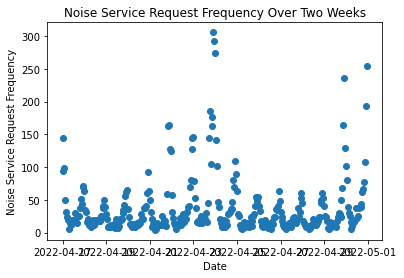

In [32]:
plt.scatter(df_counts['Date'], df_counts['Number of Noise Requests'])
# Adding labels to the scatter plot
plt.title("Noise Service Request Frequency Over Two Weeks")
plt.xlabel("Date")
plt.ylabel("Noise Service Request Frequency")

From this graph we can see the number of residential noise service requests over appears periodic with some outliers. Now we're going to determine if the time series is stationary, meaning it has a constant mean and variance over time, and there is no seasonality. To test whether the time series is stationary or not, we're going to perform an [augmented Dickey-Fuller test](https://www.statology.org/dickey-fuller-test-python/). The null hypothesis will be that time series for residential noise service requests in the two weeks is not stationary, meaning that it has some time dependent structure to it. The alternative hypothesis is that the time series is stationary. For the test we are going to set the significance value alpha to be 0.05.

In [33]:
result = adfuller(df_counts['Number of Noise Requests'].values)
print("Result: " + str(result))
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

Result: (-5.519897675887544, 1.887977073290685e-06, 6, 329, {'1%': -3.4503836022181056, '5%': -2.8703653471616826, '10%': -2.571471939191249}, 2837.866691897795)
ADF Statistic: -5.519897675887544
p-value: 1.887977073290685e-06


The p-value is 1.6370991469219969e-06 which is less than 0.05. Thus we can reject the null hypothesis and say that the time series is stationary. The ADF statistic is approximately -5.5489 and the more negative it is, the stronger the rejection of the null hypothesis. This means that the time series for total number of noise requests for each hour over this two week period is stationary. It is not dependent on time and the variance and mean stay constant. When we looked at the data of noise requests per hour of time it seemed periodic but there are many outliers that don't fall into the rest of the periodic structure of the scatter plot seen above.

## Insights

Now that we have conducted exploratory data analysis and ran statistical tests to determine whether our suspicions regarding the analysis were true or false, we can draw some conclusions on the data.

For residential noise service requests the data was not dependent on time for the two weeks we analyzed as seen from the hypothesis testing. If we were to use a larger sample size of time, such as 5 years, we might have seen different results on time dependency and if that time series was stationary or not. There was more noise at night and during weekends, which makes sense. This is probably true anywhere not just New York City so it ended up not being as important of a factor in deciding whether to live there or not.

In terms of boroughs, we were able to show that in all metrics, there is a statistically significant difference in with the number of requests. Using this information, combined with the graphs we created in the exploratory data analysis section regarding requests, requests per capita, and requests per square mile, we can clearly see that Staten Island is the best borough to live in from a strict convenience standpoint as we have defined through this tutorial. Does this definitively mean that Staten Island is the best borough to live in when trying to stay in New York City? Not at all. Despite putting a high priority on convenience and safety, neither of us believe that Staten Island would be our first preference due to other factors (job opportunity, social life). We could aggregate a defined list of "which borough is the best for x category" and combine them all to form a generalized ranking if we were to continue this analysis in the future.